In [23]:
import numpy as np
import pylab as plt
from hera_sim.antpos import linear_array, hex_array
from hera_filters import dspec
from jax import numpy as jnp
from hera_cal import abscal, redcal, datacontainer, apply_cal
from stefcal import calibration
from copy import deepcopy
import jax
from hera_sim import vis, utils
from scipy import stats
jax.config.update("jax_enable_x64", True)
%matplotlib notebook
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [104]:
nfreqs = 1500
freqs = np.linspace(50e6, 250e6, nfreqs)
antpos = hex_array(6, split_core=True)
reds = redcal.get_reds(antpos)

gains = {
    (k, 'Jnn'): np.random.normal(1, 0.1, size=(1, nfreqs)) * np.exp(-1j * np.random.uniform(0, 0.25 * np.pi, (1, nfreqs)))
    for k in antpos
}

_gains, model_vis, data_vis = vis.sim_red_data(reds, shape=(1, nfreqs), gains=gains)
model_vis = datacontainer.RedDataContainer(model_vis, reds=reds)
data_vis = datacontainer.DataContainer(data_vis)


noise_scale = 1e-6
for k in data_vis:
    data_vis[k] += np.random.normal(0, noise_scale, size=(1, nfreqs)) + 1j * np.random.normal(0, noise_scale, size=(1, nfreqs))
    
flags = datacontainer.DataContainer({k: np.zeros(data_vis[k].shape, dtype=bool) for k in data_vis})

In [118]:
len(model_vis.keys()), len(data_vis.keys())

(1755, 6555)

In [105]:
%%time
gains_stef, niter, conv_crit = calibration.sky_calibration(
    data_vis, model_vis, flags, maxiter=1000, tol=1e-10, stepsize=0.5
)
data_vis_copy = deepcopy(data_vis)
apply_cal.calibrate_in_place(data_vis_copy, gains_stef)

CPU times: user 6.36 s, sys: 292 ms, total: 6.66 s
Wall time: 6.67 s


In [106]:
%%time
chisq, nobs, chisq_per_ant, nobs2 = redcal.utils.chisq(data_vis_copy, model_vis)

CPU times: user 388 ms, sys: 7.8 ms, total: 396 ms
Wall time: 403 ms


In [107]:
chi2 = stats.chi2(len(antpos))
x = np.linspace(chi2.ppf(0.01), chi2.ppf(0.9999), 100)
pdf = chi2.pdf(x)

<IPython.core.display.Javascript object>


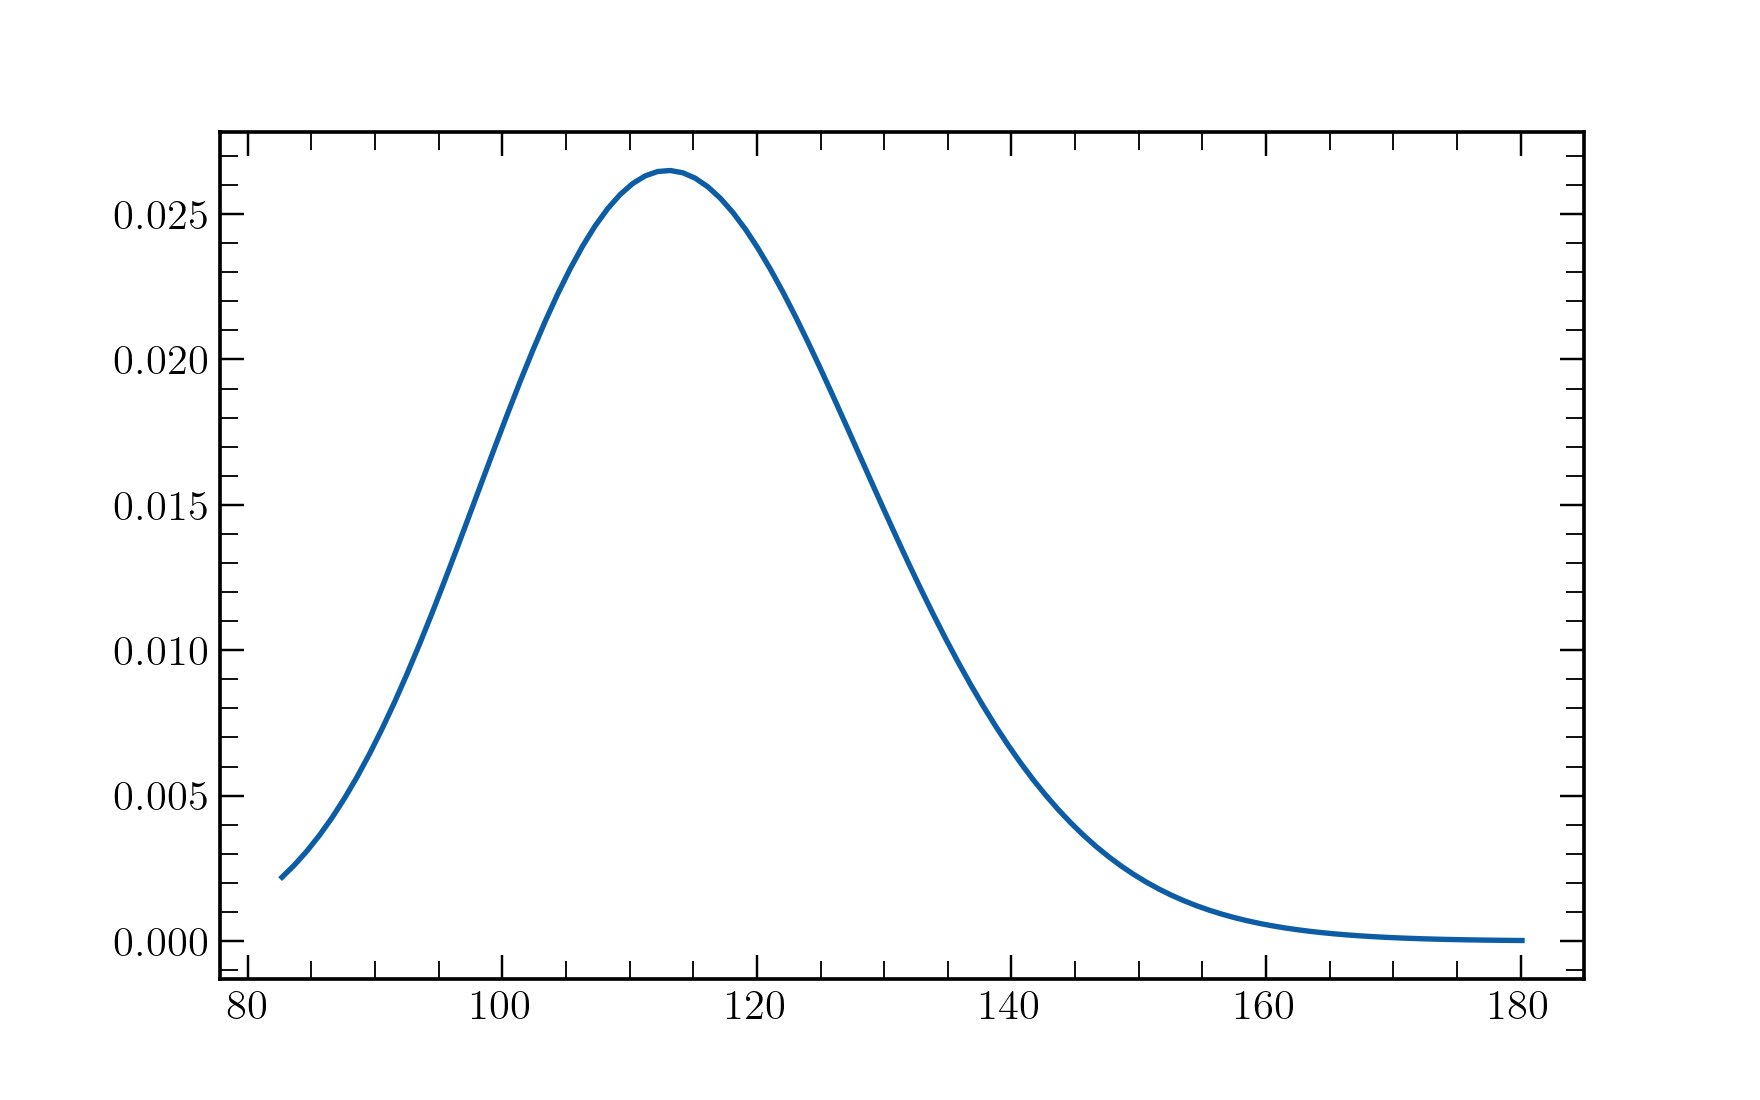

In [108]:
plt.figure()
plt.plot(x, pdf)

<IPython.core.display.Javascript object>


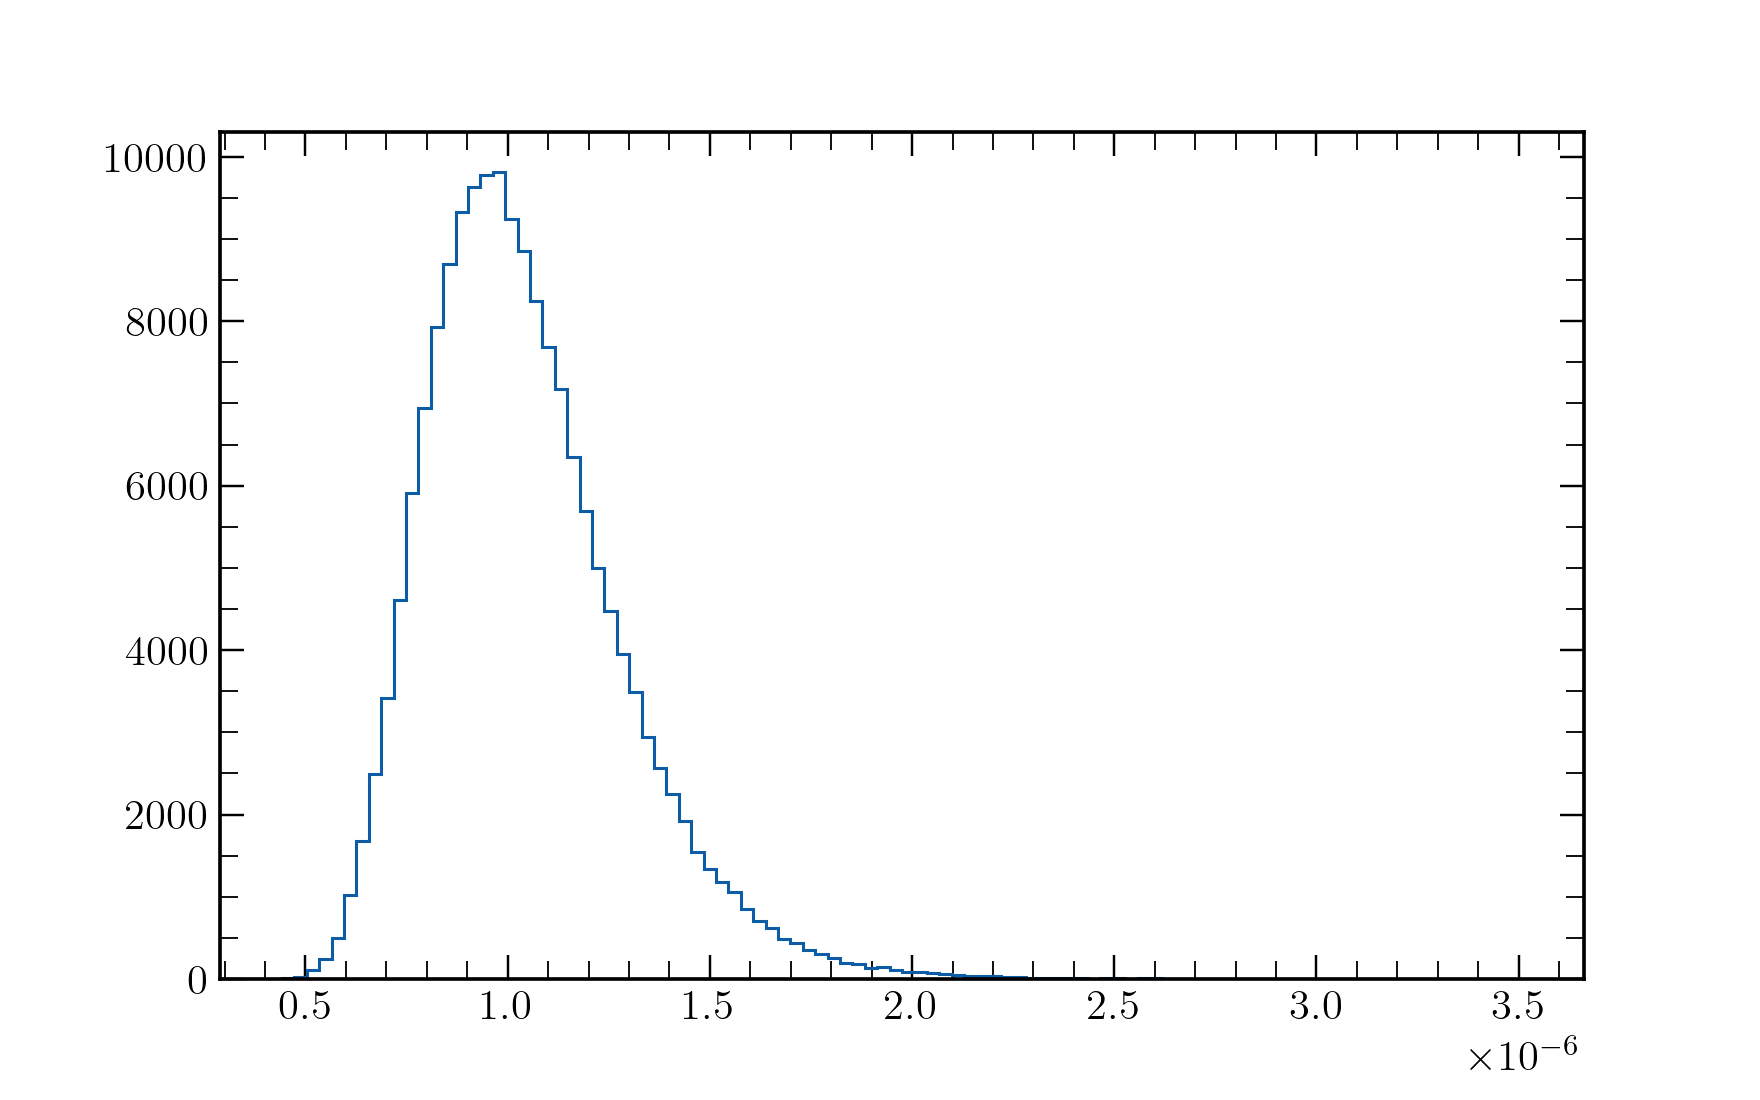

In [109]:
plt.figure()
chis = []
for k in chisq_per_ant:
    chis.append((chisq_per_ant[k][0] / (2 * noise_scale) / nobs2[k])[0])
    
plt.hist(np.ravel(chis), bins=100, histtype='step')
plt.show()

<IPython.core.display.Javascript object>


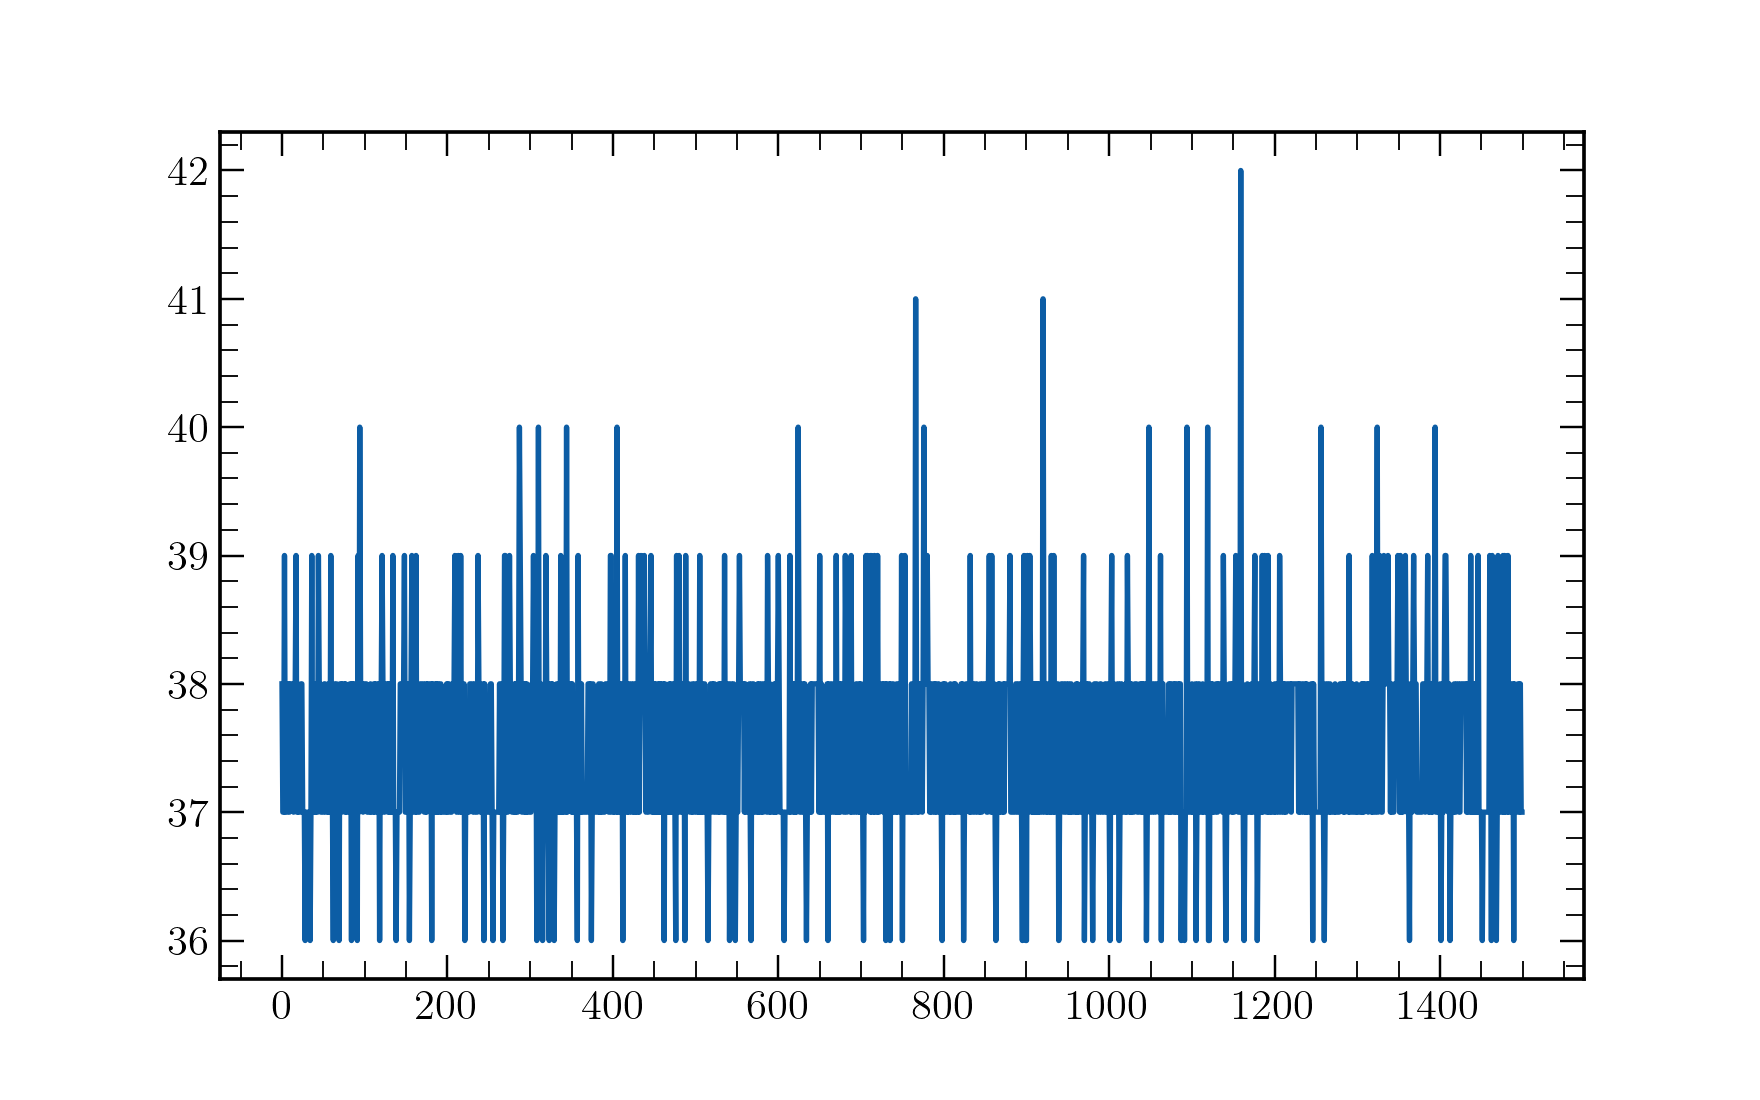

In [110]:
plt.figure()
plt.plot(niter['nn'].T)

In [111]:
import uvtools
def delay_spectra(x):
    """
    """
    return np.abs(uvtools.utils.FFT(x, taper='bh7'))

<IPython.core.display.Javascript object>


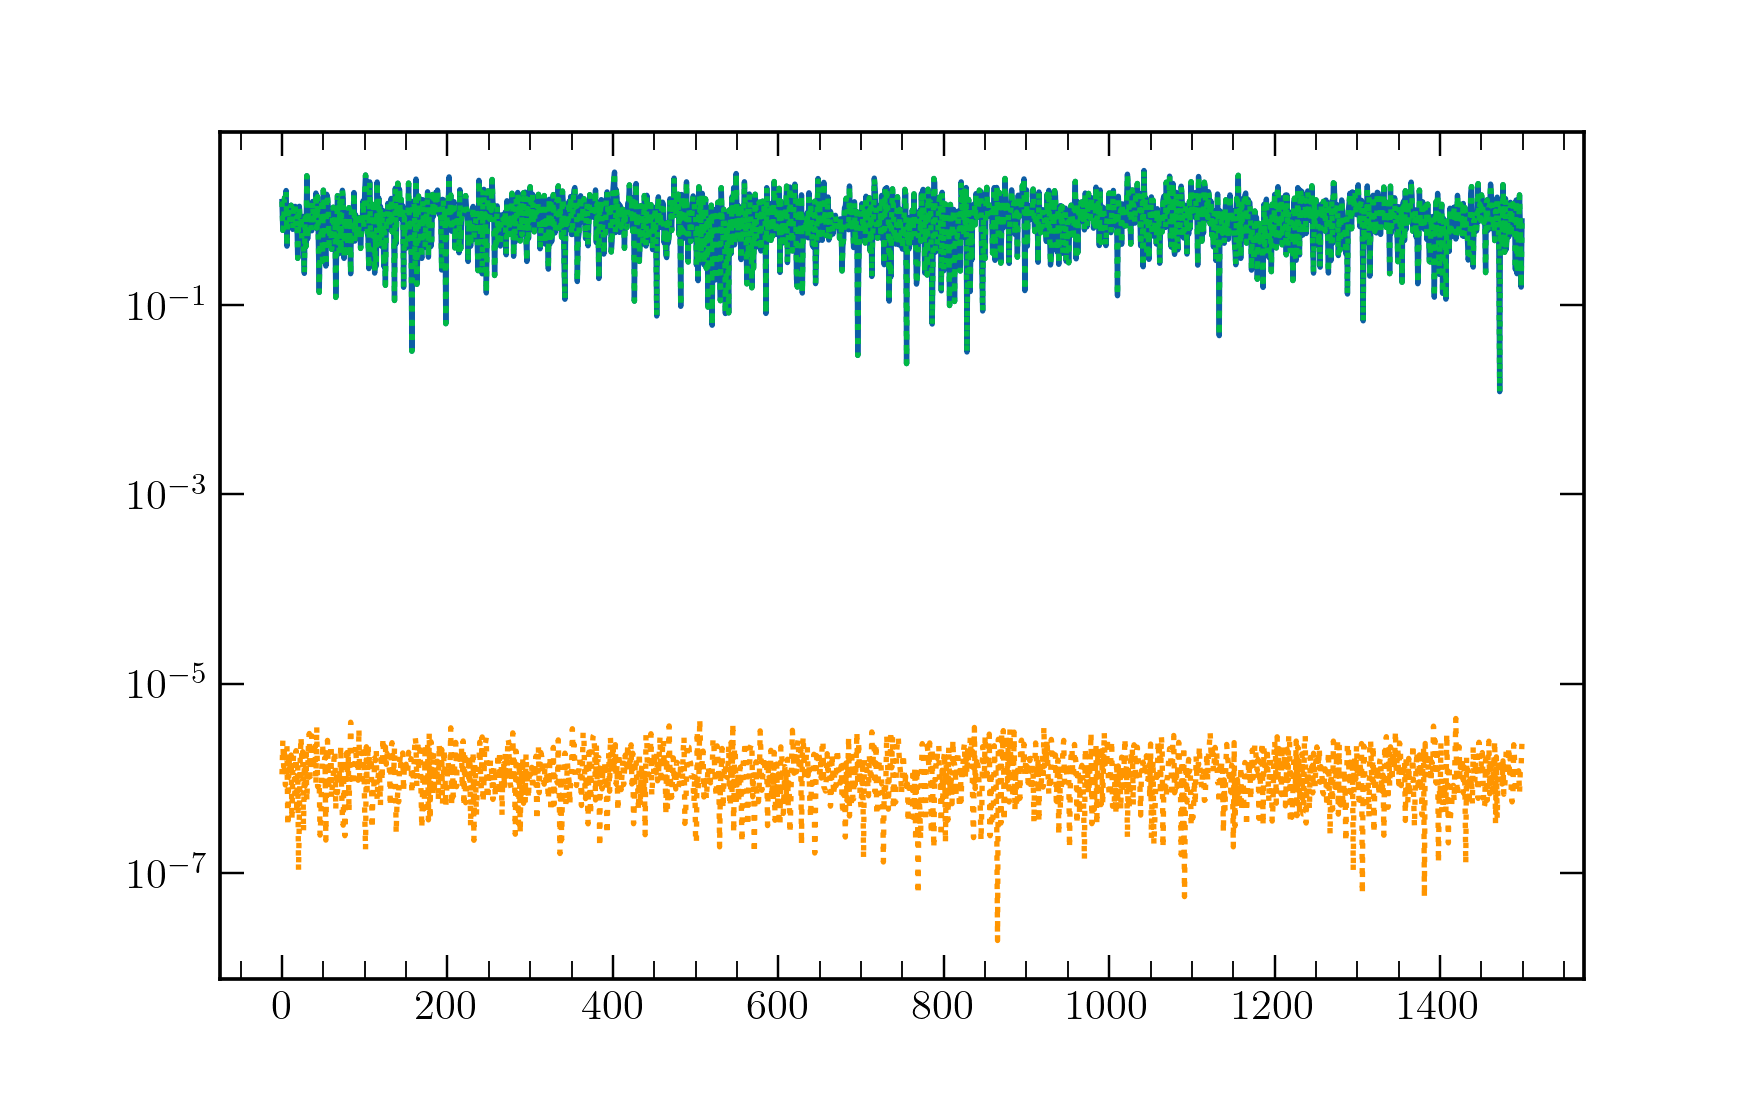

In [112]:
plt.figure()
plt.semilogy(np.abs(model_vis[0, 3, 'nn'][0]), label='Truth')
plt.semilogy(np.abs(data_vis_copy[0, 3, 'nn'][0]), ls=':', label='Calibrated Data')
plt.semilogy(np.abs(model_vis[0, 3, 'nn'][0] - data_vis_copy[0, 3, 'nn'][0]), ls=':', label='Residuals')
#plt.semilogy(delay_spectra(model_matrix[0, 20] - cal_f[0, 20]), ls='-', label='')
plt.show()

## Abscal Approach

In [113]:
ants = list(antpos.keys())

In [114]:
%%time
vis_dict_copy = deepcopy(data_vis)
vis_dict_copy = datacontainer.DataContainer(vis_dict_copy)

# Amplitude fit
amp_fit = abscal.amp_logcal(model_vis, vis_dict_copy, verbose=False)    
phs_fit = abscal.phs_logcal(model_vis, vis_dict_copy, verbose=False)

gains = {}
for k in antpos:
    gains[(k, 'Jnn')] = np.exp(amp_fit[f'eta_{k}_Jnn'] + 1j * phs_fit[f'phi_{k}_Jnn'])
    
apply_cal.calibrate_in_place(vis_dict_copy, gains)

CPU times: user 55.8 s, sys: 11.2 s, total: 1min 6s
Wall time: 35.6 s


<IPython.core.display.Javascript object>


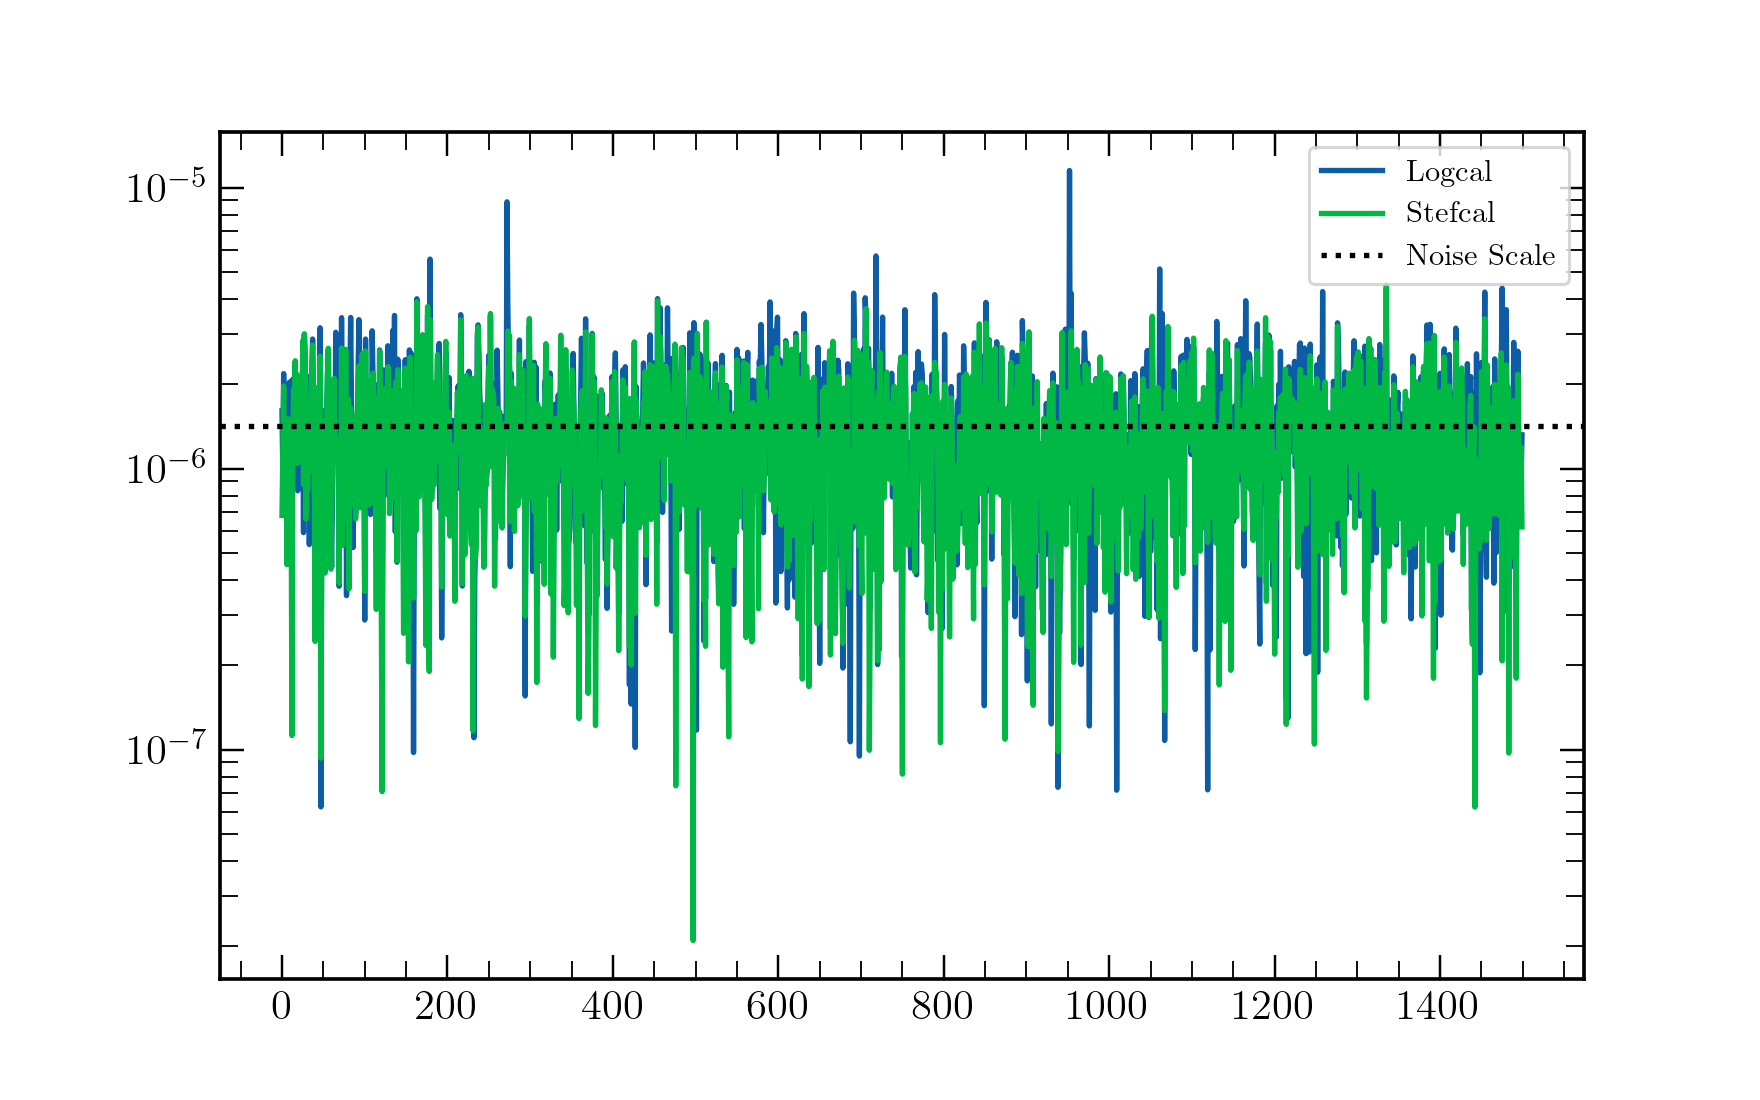

In [115]:
plt.figure()
plt.semilogy(np.abs(vis_dict_copy[(0, 2, 'nn')][0] - model_vis[(0, 2, 'nn')][0]), ls='-', label='Logcal')
plt.semilogy(np.abs(data_vis_copy[0, 2, 'nn'][0] - model_vis[0, 2, 'nn'][0]), ls='-', label='Stefcal')
plt.axhline(noise_scale * np.sqrt(2), color='k', ls=':', label='Noise Scale')
plt.legend()
plt.show()

In [116]:
len(antpos)

115